In [ ]:
!pip install pyforest

  Preparing metadata (setup.py) ... done
  Created wheel for pyforest: filename=pyforest-1.1.2-py2.py3-none-any.whl size=15900 sha256=5b278539cc554c0b5713d95cdad7a60a00095197060450fe3b3a4cc7917356af
  Stored in directory: /root/.cache/pip/wheels/c5/ca/73/5cdc3d087111bfbdef90be5457aa03c00c0e32241b2752445c
Successfully built pyforest


In [ ]:
# import all the libraries
import pyforest
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import pickle
import re
import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

In [ ]:
FILE_PATH = "https://raw.githubusercontent.com/HarpyTech/DSAI-MTech/main/ML-1/data-sets/hackathon/train.csv" #@param {type:"string"}

house_prices = pd.read_csv(FILE_PATH)

house_prices.head()

<IPython.core.display.Javascript object>

,ID,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [ ]:
TEST_FILE_PATH = "https://raw.githubusercontent.com/HarpyTech/DSAI-MTech/main/ML-1/data-sets/hackathon/test.csv" #@param {type:"string"}

test_data = pd.read_csv(TEST_FILE_PATH)

test_data.head()

<IPython.core.display.Javascript object>

,ID,area_type,availability,location,size,society,total_sqft,bath,balcony
0,0,Super built-up Area,Ready To Move,Chamrajpet,2 BHK,NaN,650,1.0,1.0
1,1,Super built-up Area,Ready To Move,7th Phase JP Nagar,3 BHK,SrncyRe,1370,2.0,1.0
2,2,Super built-up Area,Ready To Move,Whitefield,3 BHK,AjhalNa,1725,3.0,2.0
3,3,Built-up Area,Ready To Move,Jalahalli,2 BHK,NaN,1000,2.0,0.0
4,4,Plot Area,Ready To Move,TC Palaya,1 Bedroom,NaN,1350,1.0,0.0


In [ ]:
class TotalSqFtTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        total_sqft = X['total_sqft']
        total_sqmts = total_sqft.apply(self.convert_to_sqft) * 0.09290304
        X['total_sqft'] = total_sqmts
        # X.drop(columns=['total_sqft'], inplace=True)

        return X

    @staticmethod
    def convert_to_sqft(x):
      tokens = x.split('-')
      if len(tokens) == 2:
          return (float(tokens[0]) + float(tokens[1])) / 2
      try:
          return float(x)
      except:
          try:
            if 'Sq. Meter' in x:
                num = float(re.findall("(\d+\.\d+|\d+)", x)[0])
                return num * 10.7639
            elif 'Sq. Yards' in x:
                num = float(re.findall("(\d+\.\d+|\d+)", x)[0])
                return num * 9
            elif 'Acres' in x:
                num = float(re.findall("(\d+\.\d+|\d+)", x)[0])
                return num * 43560
            elif 'Cents' in x:
                num = float(re.findall("(\d+\.\d+|\d+)", x)[0])
                return num * 435.6
            elif 'Guntha' in x:
                num = float(re.findall("(\d+\.\d+|\d+)", x)[0])
                return num * 1089
            elif 'Grounds' in x:
                num = float(re.findall("(\d+\.\d+|\d+)", x)[0])
                return num * 2400
          except:
              return np.NaN

In [ ]:
class SizeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        size = X['size']
        bhk = size.apply(self.safe_extract_int)
        X['size'] = bhk

        return X

    @staticmethod
    def safe_extract_int(x):
        try:
          return int(x.split(' ')[0])
        except (ValueError, IndexError, AttributeError):
          return np.NaN

In [ ]:
class DataTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=[]):
        self.columns = columns

        pass


    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = TotalSqFtTransformer().transform(X)
        X = SizeTransformer().transform(X)

        self.data_set = X
        self.numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns
        self.categorical_columns = X.select_dtypes(include=['object']).columns

        if self.columns:
          [self.fill_na(column=column, X=X) for column in self.columns]
          [self.apply_capping(column=column, X=X) for column in self.columns]

          X = X[self.columns] if self.columns else X
        else:
          [self.fill_na(column=column, X=X) for column in self.numerical_columns]
          [self.fill_na(column=column, X=X, is_mode=True) for column in self.categorical_columns]
          [self.apply_capping(column=column, X=X) for column in self.numerical_columns]

        return X

    @staticmethod
    def apply_capping(column, X):
        Q1 = X[column].quantile(0.25)
        Q3 = X[column].quantile(0.75)
        IQR = Q3 - Q1

        # Define the upper and lower bounds
        upper_bound = Q3 + 1.5 * IQR
        lower_bound = Q1 - 1.5 * IQR
        q_10 = X[column].quantile(0.10)
        q_90 = X[column].quantile(0.9)

        # Apply capping
        X[column] = np.where(X[column] < lower_bound, q_10, X[column])
        X[column] = np.where(X[column] > upper_bound, q_90, X[column])

        return X

    @staticmethod
    def fill_na(column, X, is_mode=False):
        X[column].fillna(X[column].mode() if is_mode else X[column].median(), inplace=True)

        return X


In [ ]:
data_set = DataTransformer().transform(house_prices.copy())

data_set.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,ID,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,0.0,Super built-up Area,19-Dec,Electronic City Phase II,2.0,Coomee,98.105610,2.0,1.0,39.07
1,1.0,Plot Area,Ready To Move,Chikka Tirupathi,4.0,Theanmp,227.612448,4.0,3.0,120.00
2,2.0,Built-up Area,Ready To Move,Uttarahalli,3.0,NaN,133.780378,2.0,3.0,62.00
3,3.0,Super built-up Area,Ready To Move,Lingadheeranahalli,3.0,Soiewre,141.305524,3.0,1.0,95.00
4,4.0,Super built-up Area,Ready To Move,Kothanur,2.0,NaN,111.483648,2.0,1.0,51.00


In [ ]:
data_set.isnull().sum()

,0
ID,0
area_type,0
availability,0
location,1
size,0
society,4428
total_sqft,0
bath,0
balcony,0
price,0


<IPython.core.display.Javascript object>

<Axes: xlabel='location', ylabel='count'>

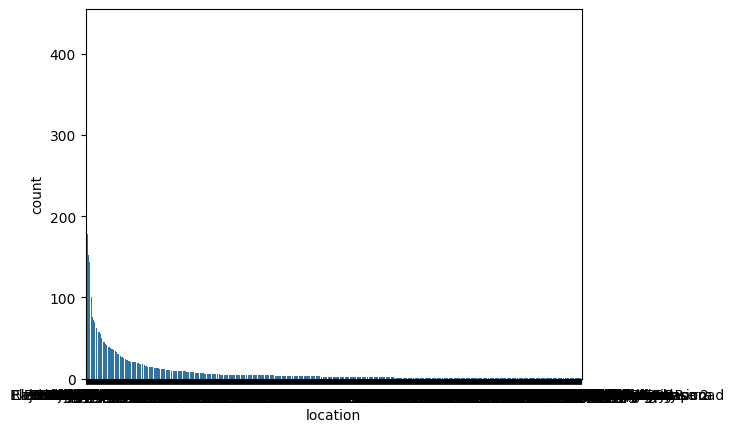

In [ ]:
sns.barplot(data_set.location.value_counts())

In [ ]:
locations = pd.DataFrame(data_set.location.value_counts())
locations.head()

<IPython.core.display.Javascript object>

,count
location,
Whitefield,433
Sarjapur Road,303
Electronic City,234
Kanakpura Road,217
Thanisandra,178


In [ ]:
locations.columns


Index(['count'], dtype='object')

In [ ]:
locations.reset_index().head()

,location,count
0,Whitefield,433
1,Sarjapur Road,303
2,Electronic City,234
3,Kanakpura Road,217
4,Thanisandra,178


In [ ]:
locations[locations['count'] < 3].shape

(632, 1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<ipython-input-51-60e2e8cdeea6>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_set[col], ax=axes[i])


<IPython.core.display.Javascript object>

<ipython-input-51-60e2e8cdeea6>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_set[col], ax=axes[i])


<IPython.core.display.Javascript object>

<ipython-input-51-60e2e8cdeea6>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_set[col], ax=axes[i])


<IPython.core.display.Javascript object>

<ipython-input-51-60e2e8cdeea6>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_set[col], ax=axes[i])


<IPython.core.display.Javascript object>

<ipython-input-51-60e2e8cdeea6>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_set[col], ax=axes[i])


<IPython.core.display.Javascript object>

<ipython-input-51-60e2e8cdeea6>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_set[col], ax=axes[i])


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

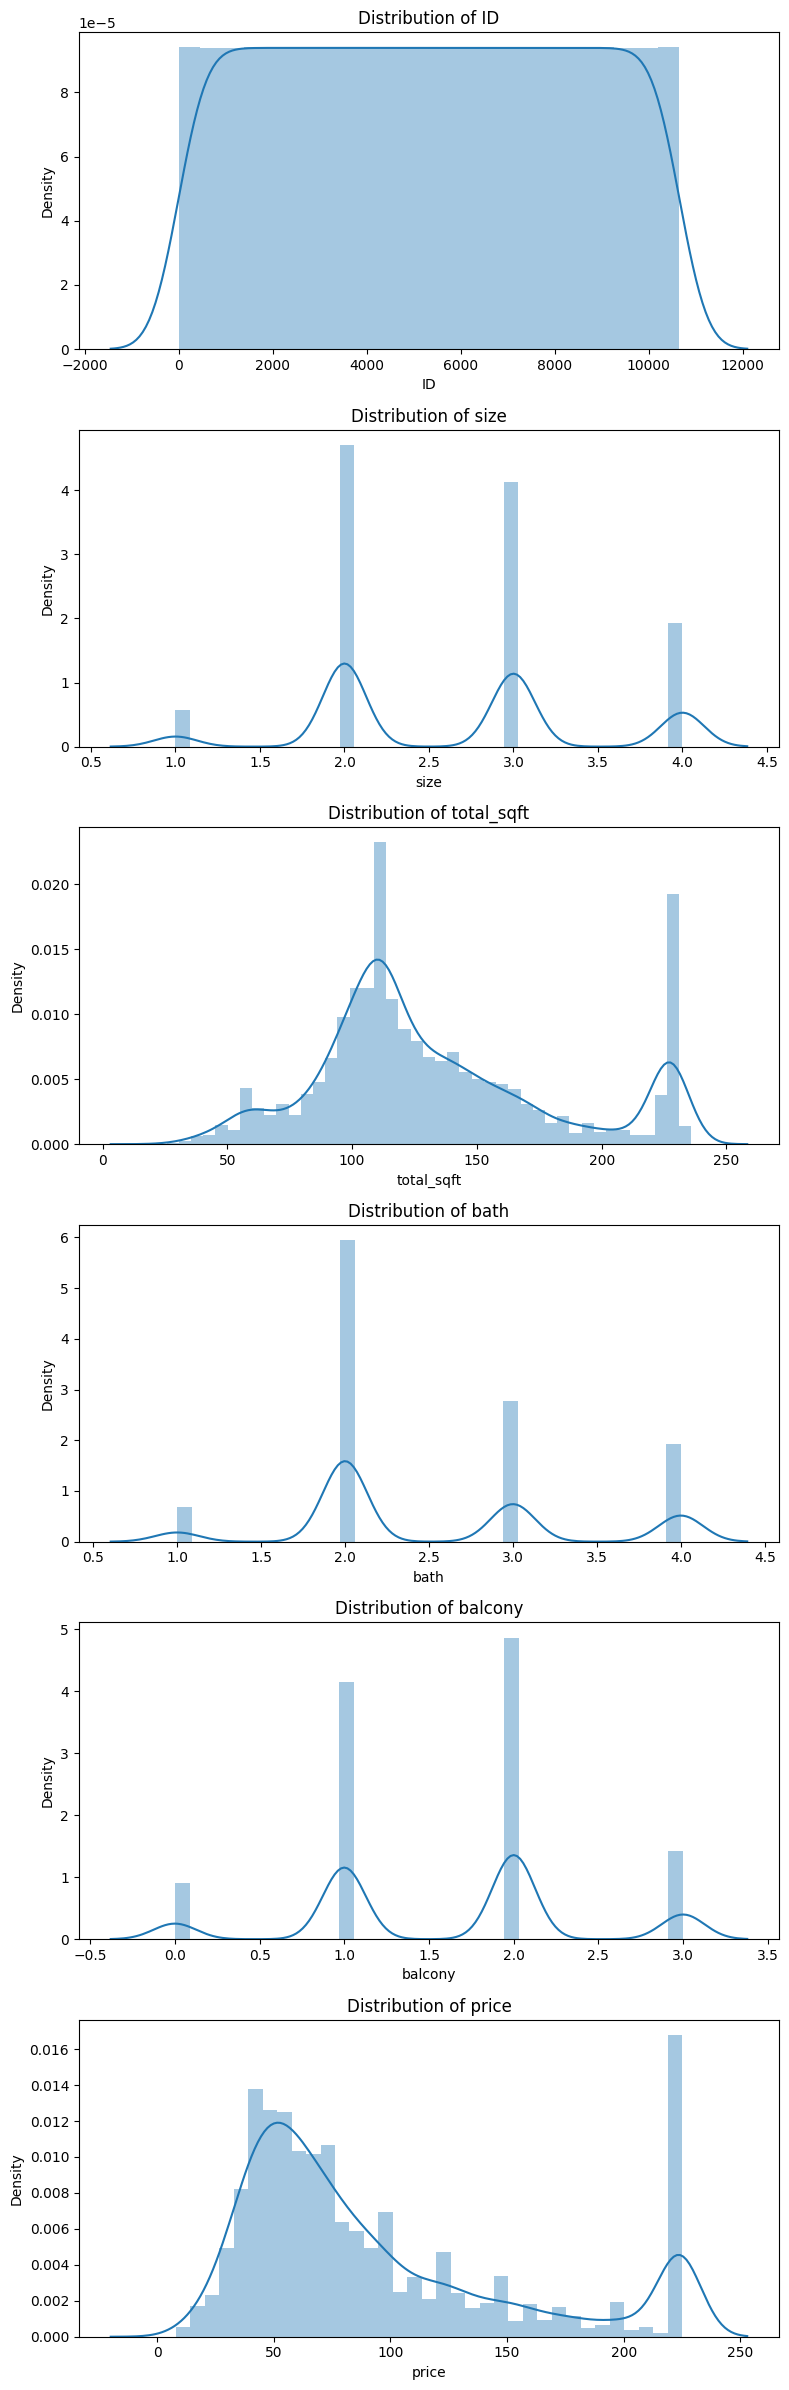

In [ ]:
# Select numerical columns
num_cols = data_set.select_dtypes(include=['int64', 'float64']).columns

# Create subplots
fig, axes = plt.subplots(nrows=len(num_cols), figsize=(8, 4 * len(num_cols)))

# Plot distplot for each numerical column
for i, col in enumerate(num_cols):
    sns.distplot(data_set[col], ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()


In [ ]:
sm.OLS(data_set['price'], sm.add_constant(data_set[['total_sqft']])).fit().summary()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                 1.414e+04
Date:                Tue, 10 Sep 2024   Prob (F-statistic):               0.00
Time:                        05:12:02   Log-Likelihood:                -54172.
No. Observations:               10656   AIC:                         1.083e+05
Df Residuals:                   10654   BIC:                         1.084e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -31.5948      1.116    -28.317      0.000     -33.782     -29.408
total_sqft     0.9451      0.008    118.926      0.000       0.929       0.961
==============================================================================
Omnibus:                     2434.498   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6218.803
Skew:                           1.243   Prob(JB):                         0.00
Kurtosis:                       5.797   Cond. No.                         414.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
sm.OLS(data_set['price'], sm.add_constant(data_set[['total_sqft', 'size']])).fit().summary()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                     8965.
Date:                Tue, 10 Sep 2024   Prob (F-statistic):               0.00
Time:                        05:12:20   Log-Likelihood:                -53414.
No. Observations:               10656   AIC:                         1.068e+05
Df Residuals:                   10653   BIC:                         1.069e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -58.6593      1.237    -47.423      0.000     -61.084     -56.235
total_sqft     0.6895      0.010     70.765      0.000       0.670       0.709
size          22.9227      0.568     40.346      0.000      21.809      24.036
==============================================================================
Omnibus:                     1277.869   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2476.032
Skew:                           0.772   Prob(JB):                         0.00
Kurtosis:                       4.786   Cond. No.                         510.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
sm.OLS(data_set['price'], sm.add_constant(data_set[['total_sqft', 'bath']])).fit().summary()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     9790.
Date:                Tue, 10 Sep 2024   Prob (F-statistic):               0.00
Time:                        05:12:33   Log-Likelihood:                -53115.
No. Observations:               10656   AIC:                         1.062e+05
Df Residuals:                   10653   BIC:                         1.063e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -57.4402      1.143    -50.243      0.000     -59.681     -55.199
total_sqft     0.6433      0.010     67.509      0.000       0.625       0.662
bath          26.0223      0.538     48.335      0.000      24.967      27.078
==============================================================================
Omnibus:                     1565.202   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3531.266
Skew:                           0.863   Prob(JB):                         0.00
Kurtosis:                       5.230   Cond. No.                         482.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
sm.OLS(data_set['price'], sm.add_constant(data_set[['total_sqft', 'balcony']])).fit().summary()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     7080.
Date:                Tue, 10 Sep 2024   Prob (F-statistic):               0.00
Time:                        05:12:50   Log-Likelihood:                -54168.
No. Observations:               10656   AIC:                         1.083e+05
Df Residuals:                   10653   BIC:                         1.084e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -30.2818      1.214    -24.953      0.000     -32.661     -27.903
total_sqft     0.9514      0.008    115.037      0.000       0.935       0.968
balcony       -1.3407      0.488     -2.747      0.006      -2.297      -0.384
==============================================================================
Omnibus:                     2469.484   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6424.421
Skew:                           1.253   Prob(JB):                         0.00
Kurtosis:                       5.862   Cond. No.                         457.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
data_set.location.fillna(data_set.location.mode()[0], inplace=True)

In [ ]:
data = data_set[['total_sqft', 'bath', 'price', 'location', 'size']]

data.head()

,total_sqft,bath,price,location,size
0,98.105610,2.0,39.07,Electronic City Phase II,2.0
1,227.612448,4.0,120.00,Chikka Tirupathi,4.0
2,133.780378,2.0,62.00,Uttarahalli,3.0
3,141.305524,3.0,95.00,Lingadheeranahalli,3.0
4,111.483648,2.0,51.00,Kothanur,2.0


In [ ]:
data = pd.get_dummies(data, columns=['location'], dtype=int)

data.head()

<IPython.core.display.Javascript object>

,total_sqft,bath,price,size,location_ Anekal,location_ Banaswadi,location_ Basavangudi,location_ Bhoganhalli,location_ Devarabeesana Halli,location_ Devarachikkanahalli,...,"location_ravindra nagar, T.dasarahalli peenya",location_rr nagar,location_sankeswari,location_sapthagiri Layout,location_sarjapura main road,location_singapura paradise,location_t.c palya,location_tc.palya,"location_white field,kadugodi",location_whitefiled
0,98.105610,2.0,39.07,2.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,227.612448,4.0,120.00,4.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,133.780378,2.0,62.00,3.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,141.305524,3.0,95.00,3.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,111.483648,2.0,51.00,2.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
sm.OLS(data['price'], sm.add_constant(data.drop(columns=['price', 'size']))).fit().summary()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     30.12
Date:                Tue, 10 Sep 2024   Prob (F-statistic):               0.00
Time:                        05:21:33   Log-Likelihood:                -50298.
No. Observations:               10656   AIC:                         1.030e+05
Df Residuals:                    9457   BIC:                         1.117e+05
Df Model:                        1198                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
const                                                         -34.0532      1.245    -27.342      0.000     -36.495     -31.612
total_sqft                                                      0.5908      0.009     63.999      0.000       0.573       0.609
bath                                                           22.4068      0.508     44.148      0.000      21.412      23.402
location_ Anekal                                                8.3798     28.808      0.291      0.771     -48.089      64.849
location_ Banaswadi                                            17.7191     28.806      0.615      0.538     -38.747      74.185
location_ Basavangudi                                          24.8698     28.805      0.863      0.388     -31.595      81.334
location_ Bhoganhalli                                          18.2888     28.808      0.635      0.526     -38.182      74.759
location_ Devarabeesana Halli                                  19.9262     12.891      1.546      0.122      -5.342      45.195
location_ Devarachikkanahalli                                 -19.8190      8.011     -2.474      0.013     -35.522      -4.116
location_ Electronic City                                       7.8629     20.380      0.386      0.700     -32.085      47.811
location_ Mysore Highway                                       -2.4531     16.642     -0.147      0.883     -35.075      30.169
location_ Rachenahalli                                         12.1493     20.380      0.596      0.551     -27.800      52.099
location_ Sector 1 HSR Layout                                 101.1649     28.840      3.508      0.000      44.632     157.698
location_ Thanisandra                                          11.0082     16.648      0.661      0.508     -21.626      43.643
location_ Whitefield                                           13.9706     28.805      0.485      0.628     -42.494      70.435
location_ ittamadu                                             66.3053     28.803      2.302      0.021       9.845     122.766
location_ south                                                68.9269     20.388      3.381      0.001      28.962     108.892
location_1 Annasandrapalya                                     28.5575     28.809      0.991      0.322     -27.915      85.030
location_1 Giri Nagar                                          33.9445     28.806      1.178      0.239     -22.521      90.410
location_1 Immadihalli                                        -40.0555     28.806     -1.391      0.164     -96.521      16.410
location_1 Ramamurthy Nagar                                    48.5575     28.809      1.685      0.092      -7.915     105.030
location_1A

In [ ]:
sm.OLS(data['price'], sm.add_constant(data.drop(columns=['price', 'bath']))).fit().summary()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     28.16
Date:                Tue, 10 Sep 2024   Prob (F-statistic):               0.00
Time:                        05:21:03   Log-Likelihood:                -50580.
No. Observations:               10656   AIC:                         1.036e+05
Df Residuals:                    9457   BIC:                         1.123e+05
Df Model:                        1198                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
const                                                         -33.5852      1.318    -25.482      0.000     -36.169     -31.002
total_sqft                                                      0.6180      0.010     63.925      0.000       0.599       0.637
size                                                           19.9157      0.540     36.883      0.000      18.857      20.974
location_ Anekal                                                9.5188     29.582      0.322      0.748     -48.468      67.505
location_ Banaswadi                                            18.4147     29.580      0.623      0.534     -39.569      76.399
location_ Basavangudi                                          25.2052     29.580      0.852      0.394     -32.778      83.188
location_ Bhoganhalli                                          19.5663     29.582      0.661      0.508     -38.421      77.554
location_ Devarabeesana Halli                                  22.4321     13.237      1.695      0.090      -3.515      48.380
location_ Devarachikkanahalli                                 -22.6238      8.225     -2.751      0.006     -38.747      -6.501
location_ Electronic City                                       8.6453     20.928      0.413      0.680     -32.378      49.669
location_ Mysore Highway                                       -8.4088     17.087     -0.492      0.623     -41.903      25.085
location_ Rachenahalli                                         13.0987     20.929      0.626      0.531     -27.926      54.123
location_ Sector 1 HSR Layout                                  97.0163     29.621      3.275      0.001      38.952     155.080
location_ Thanisandra                                          11.8012     17.097      0.690      0.490     -21.713      45.315
location_ Whitefield                                           13.7139     29.581      0.464      0.643     -44.270      71.698
location_ ittamadu                                             49.3925     29.583      1.670      0.095      -8.596     107.381
location_ south                                                48.6623     20.926      2.325      0.020       7.642      89.682
location_1 Annasandrapalya                                     35.0311     29.582      1.184      0.236     -22.956      93.018
location_1 Giri Nagar                                          37.2692     29.579      1.260      0.208     -20.712      95.250
location_1 Immadihalli                                        -36.7308     29.579     -1.242      0.214     -94.712      21.250
location_1 Ramamurthy Nagar                                    55.0311     29.582      1.860      0.063      -2.956     113.018
location_1A

In [ ]:
LinearRegression().fit(data.drop(columns=['price']), data['price']).score(data.drop(columns=['price']), data['price'])

<IPython.core.display.Javascript object>

0.7938809134434502

In [ ]:
LinearRegression().fit(data.drop(columns=['price', 'bath']), data['price']).score(data.drop(columns=['price', 'bath']), data['price'])

<IPython.core.display.Javascript object>

0.7810242581225184

In [ ]:
LinearRegression().fit(data.drop(columns=['price', 'size']), data['price']).score(data.drop(columns=['price', 'size']), data['price'])

<IPython.core.display.Javascript object>

0.7923255752881659

In [ ]:
data.head()

,total_sqft,bath,price,size,location_ Anekal,location_ Banaswadi,location_ Basavangudi,location_ Bhoganhalli,location_ Devarabeesana Halli,location_ Devarachikkanahalli,...,"location_ravindra nagar, T.dasarahalli peenya",location_rr nagar,location_sankeswari,location_sapthagiri Layout,location_sarjapura main road,location_singapura paradise,location_t.c palya,location_tc.palya,"location_white field,kadugodi",location_whitefiled
0,98.105610,2.0,39.07,2.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,227.612448,4.0,120.00,4.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,133.780378,2.0,62.00,3.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,141.305524,3.0,95.00,3.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,111.483648,2.0,51.00,2.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
data_set.head()

,ID,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,0.0,Super built-up Area,19-Dec,Electronic City Phase II,2.0,Coomee,98.105610,2.0,1.0,39.07
1,1.0,Plot Area,Ready To Move,Chikka Tirupathi,4.0,Theanmp,227.612448,4.0,3.0,120.00
2,2.0,Built-up Area,Ready To Move,Uttarahalli,3.0,NaN,133.780378,2.0,3.0,62.00
3,3.0,Super built-up Area,Ready To Move,Lingadheeranahalli,3.0,Soiewre,141.305524,3.0,1.0,95.00
4,4.0,Super built-up Area,Ready To Move,Kothanur,2.0,NaN,111.483648,2.0,1.0,51.00


In [ ]:
test_data_set = DataTransformer().transform(test_data.copy())

test_data_set.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,ID,area_type,availability,location,size,society,total_sqft,bath,balcony
0,0.0,Super built-up Area,Ready To Move,Chamrajpet,2.0,PrarePa,60.386976,1.0,1.0
1,1.0,Super built-up Area,Ready To Move,7th Phase JP Nagar,3.0,SrncyRe,127.277165,2.0,1.0
2,2.0,Super built-up Area,Ready To Move,Whitefield,3.0,AjhalNa,160.257744,3.0,2.0
3,3.0,Built-up Area,Ready To Move,Jalahalli,2.0,NaN,92.903040,2.0,0.0
4,4.0,Plot Area,Ready To Move,TC Palaya,1.0,NaN,125.419104,1.0,0.0


In [ ]:
# Numerical Columns
num_clos = ['total_sqft', 'bath', 'size']

# Categorical Columns
cat_clos = ['location']

num_pipe = Pipeline(steps=[
    ('pre_process', DataTransformer(columns=num_clos)),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipe, num_clos),
    ('cat', cat_pipe, cat_clos)
], remainder='passthrough')


In [ ]:
full_pipe_rfr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor())
])

features = house_prices[['total_sqft', 'bath', 'location', 'size']]

full_pipe_rfr.fit(features, house_prices['price'])

full_pipe_rfr.score(features, house_prices['price'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.8449254514103988

In [ ]:
from sklearn.linear_model import LinearRegression

full_pipe_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression()   )
])

features = house_prices[['total_sqft', 'bath', 'location', 'size']]

full_pipe_lr.fit(features, house_prices['price'])

full_pipe_lr.score(features, house_prices['price'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.5868589088712017

In [ ]:
test_data.head()

,ID,area_type,availability,location,size,society,total_sqft,bath,balcony
0,0,Super built-up Area,Ready To Move,Chamrajpet,2 BHK,NaN,650,1.0,1.0
1,1,Super built-up Area,Ready To Move,7th Phase JP Nagar,3 BHK,SrncyRe,1370,2.0,1.0
2,2,Super built-up Area,Ready To Move,Whitefield,3 BHK,AjhalNa,1725,3.0,2.0
3,3,Built-up Area,Ready To Move,Jalahalli,2 BHK,NaN,1000,2.0,0.0
4,4,Plot Area,Ready To Move,TC Palaya,1 Bedroom,NaN,1350,1.0,0.0


In [ ]:
rfr_output = full_pipe_rfr.predict(test_data[features.columns])

lr_output = full_pipe_lr.predict(test_data[features.columns])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ValueError: Found unknown categories ['Dominic Layout', 'Shanthi Pura', 'Pattegarhpalya', 'Pillanna Gardens', 'Wheelers Road', 'Postal Colony', 'Park View Layout', 'Medaralli', 'Sarvobhogam Nagar', 'Sadhguru Layout', 'Kanakapura main  Road', 'Kengeri Satellite Town KHB Apartment', 'Annaiah Reddy Layout', 'Xavier Layout', 'Arishinakunte', 'Bhoopsandra', 'adigondanhalli', 'Allalasandra', 'Whitefield ECC Road', 'Akash Nagar', 'Jakkasandra', 'kadubisnahalli', 'vinayakanagar', 'Ashraya Layout', 'Banasawadi, ', '3rd Stage Raja Rajeshwari Nagar', 'Maruthi nagar kogilu', 'Raja Rajashweri Nagar', 'MM Layout', 'Banagirinagar', 'Chikkanahalli', 'beml layout, basaveshwara nagar', 'Doctor Layout Rayasandra', 'RBI Layout', 'Devarabeesana Halli', 'akshaya nagar t c palya', 'Gubbi Cross, Hennur Main Road', 'Sabari Nagar', 'Hanuman Nagar', 'Chikbasavanapura', 'Jogupalya', 'Chuchangatta Colony', 'Mallappa Layout', 'KAMAKIYA', 'Thyagraj Nagar', 'Banashankari Stage I', 'Zuzuvadi', 'Sunkan palya', 'arudi', 'pavitra paradise', '4th Block HBR Layout', 'Rahmath Nagar', 'Amam Enclave Layout', 'Bapuji Nagar', 'Ayappa Nagar', 'Chellikere', 'Jaraganahalli Jp Nagar Post', 'basaveshwarnagar', 'Masjid e Alkareem', 'Off Bannergatta Road', 'Infantry Road', 'Chikkajala', 'Banashankari 3rd stage, Vivekanandanagar', 'Anathanagar', 'Air View Colony', 'Abshot Layout', 'Kanakapur main road', 'Maheswari Nagar', '1Kasavanhalli', 'Electronic City Phase 1, ', 'Duddanahalli', 'Electronic city phase 1, ', 'MEI layout, Bagalgunte', 'Vijaypura', 'Halanayakanahalli', 'Old Mangammanapalya Road', 'Anwar Layout', 'Jeevanhalli', 'Kanakapura  Rod', 'Anantapuram', 'Kanakapura Road, ', 'Subhash Nagar', 'Tilak Nagar', 'Gayathri Nagar', 'LIC Colony', 'Richmond Road', 'Sindhi Colony', 'Udayagiri', 'Viviani Road', 'Michael Palaya', 'Doddanakunte', 'mvj engineering college', 'Billamaranahalli', 'Gulakamale', '12th cross srinivas nagar banshankari 3rd stage', 'Ramanagara Channapatna', 'Prasanti Nagar', 'Hal old airport road', 'Hsr layout sector3', 'Beml layout, Rajarajeshwari nagar', 'Javarandoddi', 'manyata', 'Shauhardha Layout', 'Sampangirama Nagar', 'AECS LAYOUT A-BLOCK Singasandra', 'Prasanna layout Herohalli', 'Versova Layout', 'Havanur extension'] in column 0 during transform

In [ ]:
# LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

# Numerical Columns
num_clos = ['total_sqft', 'bath', 'size']

# Categorical Columns
cat_clos = ['location']

num_pipe = Pipeline(steps=[
    ('pre_process', DataTransformer(columns=num_clos)),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder()) # Alternative to the Label Encoder
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipe, num_clos),
    ('cat', cat_pipe, cat_clos)
], remainder='passthrough')

full_pipe_rfr_label = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor())
])

features = house_prices[['total_sqft', 'bath', 'location', 'size']]

full_pipe_rfr_label.fit(features, house_prices['price'])

full_pipe_rfr_label.score(features, house_prices['price'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.8431296837905815

In [ ]:
label_out = full_pipe_rfr_label.predict(test_data[features.columns])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ValueError: Found unknown categories ['Dominic Layout', 'Shanthi Pura', 'Pattegarhpalya', 'Pillanna Gardens', 'Wheelers Road', 'Postal Colony', 'Park View Layout', 'Medaralli', 'Sarvobhogam Nagar', 'Sadhguru Layout', 'Kanakapura main  Road', 'Kengeri Satellite Town KHB Apartment', 'Annaiah Reddy Layout', 'Xavier Layout', 'Arishinakunte', 'Bhoopsandra', 'adigondanhalli', 'Allalasandra', 'Whitefield ECC Road', 'Akash Nagar', 'Jakkasandra', 'kadubisnahalli', 'vinayakanagar', 'Ashraya Layout', 'Banasawadi, ', '3rd Stage Raja Rajeshwari Nagar', 'Maruthi nagar kogilu', 'Raja Rajashweri Nagar', 'MM Layout', 'Banagirinagar', 'Chikkanahalli', 'beml layout, basaveshwara nagar', 'Doctor Layout Rayasandra', 'RBI Layout', 'Devarabeesana Halli', 'akshaya nagar t c palya', 'Gubbi Cross, Hennur Main Road', 'Sabari Nagar', 'Hanuman Nagar', 'Chikbasavanapura', 'Jogupalya', 'Chuchangatta Colony', 'Mallappa Layout', 'KAMAKIYA', 'Thyagraj Nagar', 'Banashankari Stage I', 'Zuzuvadi', 'Sunkan palya', 'arudi', 'pavitra paradise', '4th Block HBR Layout', 'Rahmath Nagar', 'Amam Enclave Layout', 'Bapuji Nagar', 'Ayappa Nagar', 'Chellikere', 'Jaraganahalli Jp Nagar Post', 'basaveshwarnagar', 'Masjid e Alkareem', 'Off Bannergatta Road', 'Infantry Road', 'Chikkajala', 'Banashankari 3rd stage, Vivekanandanagar', 'Anathanagar', 'Air View Colony', 'Abshot Layout', 'Kanakapur main road', 'Maheswari Nagar', '1Kasavanhalli', 'Electronic City Phase 1, ', 'Duddanahalli', 'Electronic city phase 1, ', 'MEI layout, Bagalgunte', 'Vijaypura', 'Halanayakanahalli', 'Old Mangammanapalya Road', 'Anwar Layout', 'Jeevanhalli', 'Kanakapura  Rod', 'Anantapuram', 'Kanakapura Road, ', 'Subhash Nagar', 'Tilak Nagar', 'Gayathri Nagar', 'LIC Colony', 'Richmond Road', 'Sindhi Colony', 'Udayagiri', 'Viviani Road', 'Michael Palaya', 'Doddanakunte', 'mvj engineering college', 'Billamaranahalli', 'Gulakamale', '12th cross srinivas nagar banshankari 3rd stage', 'Ramanagara Channapatna', 'Prasanti Nagar', 'Hal old airport road', 'Hsr layout sector3', 'Beml layout, Rajarajeshwari nagar', 'Javarandoddi', 'manyata', 'Shauhardha Layout', 'Sampangirama Nagar', 'AECS LAYOUT A-BLOCK Singasandra', 'Prasanna layout Herohalli', 'Versova Layout', 'Havanur extension'] in column 0 during transform

In [ ]:

# Numerical Columns
num_clos = ['total_sqft', 'bath', 'size']

num_pipe = Pipeline(steps=[
    ('pre_process', DataTransformer(columns=num_clos)),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipe, num_clos)
], remainder='passthrough')

full_pipe_rfr_label = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor())
])

# RandomForestRegressor for these features it gave the 0.4733 as score values
# LinearRegression giving 0.3430 as score value
full_pipe_rfr_label.fit(house_prices[num_clos], house_prices['price'])

full_pipe_rfr_label.score(house_prices[num_clos], house_prices['price'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.4735597659783847

In [ ]:
label_out = full_pipe_rfr_label.predict(test_data[num_clos]) # This Got 144 RMSE

pd.DataFrame({'id': test_data['ID'], 'price': label_out}).to_csv('submission.csv', index=False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
distance = pd.read_csv("./dist_from_city_centre.csv")
distance.head()

<IPython.core.display.Javascript object>

,location,dist_from_city
0,Whitefield,17.3
1,Sarjapur Road,17.2
2,Electronic City,18.1
3,Kanakpura Road,26.5
4,Thanisandra,11.5


In [ ]:
rent = pd.read_csv("./avg_rent.csv")

rent.head()

<IPython.core.display.Javascript object>

,location,avg_2bhk_rent
0,Krishnarajapura,11954
1,Sarjapur,45000
2,Whitefield Hope Farm Junction,26370
3,Devanahalli,17302
4,Whitefield,14981


In [ ]:
house_prices = house_prices.merge(distance, on='location').merge(rent, on='location')

house_prices.head()

,ID,area_type,availability,location,size,society,total_sqft,bath,balcony,price,dist_from_city,avg_2bhk_rent
0,0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07,19.3,11500
1,155,Super built-up Area,18-Jul,Electronic City Phase II,2 BHK,Sryalan,1020,2.0,1.0,30.60,19.3,11500
2,292,Super built-up Area,Ready To Move,Electronic City Phase II,2 BHK,Coush W,1069,2.0,2.0,45.00,19.3,11500
3,354,Super built-up Area,18-May,Electronic City Phase II,1 BHK,SNbay G,630,1.0,1.0,28.35,19.3,11500
4,461,Super built-up Area,18-May,Electronic City Phase II,3 BHK,Sryalan,1220,2.0,1.0,35.23,19.3,11500


In [ ]:
house_prices.isnull().sum()

,0
ID,0
area_type,0
availability,0
location,0
size,7
society,1235
total_sqft,0
bath,31
balcony,148
price,0


In [ ]:
test_data = test_data.merge(distance, on='location').merge(rent, on='location')

test_data.isnull().sum()

,0
ID,0
area_type,0
availability,0
location,0
size,1
society,304
total_sqft,0
bath,3
balcony,26
dist_from_city,0


In [ ]:
house_prices.describe()

,ID,bath,balcony,price,dist_from_city,avg_2bhk_rent
count,3652.000000,3621.000000,3504.000000,3652.000000,3652.000000,3652.000000
mean,5286.503286,2.604529,1.595034,99.720155,15.612623,15137.958379
std,3039.054786,1.307615,0.815976,105.497547,6.283069,6438.571686
min,0.000000,1.000000,0.000000,8.000000,2.400000,1756.000000
25%,2672.750000,2.000000,1.000000,48.000000,11.500000,11714.000000
50%,5315.500000,2.000000,2.000000,68.450000,15.100000,14981.000000
75%,7849.250000,3.000000,2.000000,110.000000,17.300000,17340.000000
max,10650.000000,40.000000,3.000000,1800.000000,47.700000,45000.000000


In [ ]:
# Numerical Columns
num_clos = ['total_sqft', 'bath', 'size', 'dist_from_city', 'avg_2bhk_rent']

num_pipe = Pipeline(steps=[
    ('pre_process', DataTransformer(columns=num_clos)),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipe, num_clos)
], remainder='passthrough')

full_pipe_rfr_label = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor())
])

# RandomForestRegressor for these features it gave the 0.4733 as score values
# LinearRegression giving 0.3430 as score value
full_pipe_rfr_label.fit(house_prices[num_clos], house_prices['price'])

full_pipe_rfr_label.score(house_prices[num_clos], house_prices['price'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.7670616998024088

In [ ]:
label_out = full_pipe_rfr_label.predict(test_data[num_clos]) # This Got 144 RMSE

pd.DataFrame({'ID': test_data['ID'], 'price': label_out}).to_csv('submission3.csv', index=False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
house_prices.shape, test_data.shape

((3652, 12), (909, 11))

In [ ]:
rent_dict = dict({})

for location, rent in zip(rent['location'], rent['avg_2bhk_rent']):
  rent_dict[location] = rent

rent_dict

{'Krishnarajapura': 11954,
 'Sarjapur': 45000,
 'Whitefield Hope Farm Junction': 26370,
 'Devanahalli': 17302,
 'Whitefield': 14981,
 'HSR Layout': 20521,
 'Begur': 15500,
 'Electronic City Phase 1': 18891,
 'Yelahanka': 8500,
 'Thanisandra': 13500,
 'Varthur': 9483,
 'Jakkur': 18636,
 'J. P. Nagar': 17600,
 'Chandapura': 11714,
 'Marsur': 9890,
 'Electronics City': 10650,
 'Subramanyapura': 13250,
 'BTM Layout': 16765,
 'Budigere Cross': 22143,
 'Koramangala': 2117,
 'Horamavu': 17264,
 'Rajajinagar': 16792,
 'Bellandur': 19667,
 'Vignana Kendra': 29545,
 'Marathahalli': 16620,
 'Bommasandra': 15500,
 'Talaghattapura': 21711,
 'Electronic City Phase 2': 14000,
 'Mahadevapura': 18363,
 'Narayanapura on Hennur Main Road': 24903,
 'Chamrajpet': 15875,
 'Murugeshpalya': 18875,
 'Hebbal': 17340,
 'Anekal City': 7667,
 'Banashankari': 15107,
 'Bagaluru Near Yelahanka': 13750,
 'Nagarbhavi': 16334,
 'RR Nagar': 18750,
 'Indiranagar': 25318,
 'Ramamurthy Nagar': 14647,
 'Hennur': 17529,
 'Kal

In [ ]:
dist_dict = dict({})

for location, dist in zip(distance['location'], distance['dist_from_city']):
  dist_dict[location] = dist

dist_dict

{'Whitefield': 17.3,
 'Sarjapur  Road': 17.2,
 'Electronic City': 18.1,
 'Kanakpura Road': 26.5,
 'Thanisandra': 11.5,
 'Yelahanka': 20.8,
 'Uttarahalli': 12.9,
 'Hebbal': 11.1,
 'Marathahalli': 10.9,
 'Raja Rajeshwari Nagar': 15.3,
 'Hennur Road': 14.4,
 'Bannerghatta Road': 18.8,
 '7th Phase JP Nagar': 11.0,
 'Haralur Road': 14.9,
 'Electronic City Phase II': 19.3,
 'Rajaji Nagar': 9.6,
 'Chandapura': 24.0,
 'Bellandur': 12.9,
 'KR Puram': 11.9,
 'Hoodi': 13.3,
 'Electronics City Phase 1': 20.3,
 'Yeshwanthpur': 13.4,
 'Begur Road': 10.8,
 'Sarjapur': 17.2,
 'Kasavanhalli': 15.0,
 'Harlur': 16.1,
 'Banashankari': 11.2,
 'Hormavu': 11.9,
 'Ramamurthy Nagar': 11.7,
 'Kengeri': 22.5,
 'Koramangala': 8.3,
 'JP Nagar': 9.9,
 'Hosa Road': 15.7,
 'Jakkur': 12.9,
 'Old Madras Road': 4.7,
 'Varthur': 17.4,
 'Kothanur': 11.8,
 'Kaggadasapura': 8.9,
 'Nagarbhavi': 17.0,
 'Akshaya Nagar': 13.8,
 'Thigalarapalya': 15.0,
 'TC Palaya': 12.2,
 'Malleshwaram': 8.3,
 '8th Phase JP Nagar': 14.5,
 'Rach

In [ ]:
house_prices['avg_rent'] = house_prices['location'].map(rent_dict)

house_prices['dist_from_city'] = house_prices['location'].map(dist_dict)

house_prices.describe()

,ID,bath,balcony,price,avg_rent,dist_from_city
count,10656.000000,10591.000000,10152.000000,10656.000000,3665.000000,9630.000000
mean,5327.500000,2.690586,1.581757,112.214256,15363.440109,15.191080
std,3076.266568,1.352403,0.821357,142.231967,14472.805948,6.242696
min,0.000000,1.000000,0.000000,8.000000,1756.000000,1.900000
25%,2663.750000,2.000000,1.000000,50.000000,11714.000000,11.100000
50%,5327.500000,2.000000,2.000000,72.000000,14981.000000,14.400000
75%,7991.250000,3.000000,2.000000,120.000000,17340.000000,17.400000
max,10655.000000,40.000000,3.000000,2700.000000,800000.000000,47.700000


In [ ]:
test_data['avg_rent'] = test_data['location'].map(rent_dict)

test_data['dist_from_city'] = test_data['location'].map(dist_dict)

test_data.describe()

,ID,bath,balcony,avg_rent,dist_from_city
count,2664.000000,2656.000000,2559.000000,912.000000,2390.000000
mean,1331.500000,2.700678,1.594764,15986.675439,15.364644
std,769.174883,1.297112,0.800891,26712.427581,6.118146
min,0.000000,1.000000,0.000000,1756.000000,1.900000
25%,665.750000,2.000000,1.000000,11660.500000,11.500000
50%,1331.500000,2.000000,2.000000,14981.000000,14.900000
75%,1997.250000,3.000000,2.000000,17529.000000,18.075000
max,2663.000000,18.000000,3.000000,800000.000000,47.700000


In [ ]:
# Numerical Columns
num_clos = ['total_sqft', 'bath', 'size', 'dist_from_city']

num_pipe = Pipeline(steps=[
    ('pre_process', DataTransformer(columns=num_clos)),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipe, num_clos)
], remainder='passthrough')

full_pipe_rfr_label = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor())
])

full_pipe_rfr_label.fit(house_prices[num_clos], house_prices['price'])

full_pipe_rfr_label.score(house_prices[num_clos], house_prices['price'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.6798604400886736

In [ ]:
label_out = full_pipe_rfr_label.predict(test_data[num_clos]) # This Got 134.82 RMSE

pd.DataFrame({'ID': test_data['ID'], 'price': label_out}).to_csv('submission3.csv', index=False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Numerical Columns
num_clos = ['total_sqft', 'size', 'dist_from_city']

num_pipe = Pipeline(steps=[
    ('pre_process', DataTransformer(columns=num_clos)),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipe, num_clos)
], remainder='passthrough')

full_pipe_rfr_label = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

# RandomForestRegressor -> 0.6672
# LinearRegression --> 0.3510

full_pipe_rfr_label.fit(house_prices[num_clos], house_prices['price'])

full_pipe_rfr_label.score(house_prices[num_clos], house_prices['price'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.3510953065282665

In [ ]:
def model_pipeline(base_model, cols):
    num_pipe = Pipeline(steps=[
        ('pre_process', DataTransformer(columns=cols)),
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer(transformers=[
        ('num', num_pipe, cols)
    ], remainder='passthrough')

    full_pipe_rfr_label = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', base_model)
    ])

    full_pipe_rfr_label.fit(house_prices[cols], house_prices['price'])

    print(full_pipe_rfr_label.score(house_prices[cols], house_prices['price']))

    return full_pipe_rfr_label

In [ ]:
from sklearn.linear_model import Ridge, Lasso

model_pipeline(Lasso(alpha=0.00001), num_clos)

model_pipeline(Ridge(alpha=100), num_clos)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.3510953065282334


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.35107676564547285


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('pre_process',
                                                                   DataTransformer(columns=['total_sqft',
                                                                                            'size',
                                                                                            'dist_from_city'])),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['total_sqft', 'size',
                                                   'dist_from_city'])])),
                ('model', Ridge(alpha=100))])